In [2]:
import pandas as pd
import os
import gzip
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import requests
import datetime
from scipy import stats
from load_helper_CoronaWiki import *
import urllib.parse
import time 
COVID_RELATED_ARTICLES_PATH = "data/COVID_related_pages_project-1.csv"
DICT_COUNTRIES_OWN_LANG = {"Italy" : "it", "Russia": "ru", "China": "zh", "India": "hi", "Albania": "sq", 
"Bangladesh": "bn", "Bostwana": "tn", "Cambogia": "km", "Croatia": "hr", "Greece": "el", "Sweden": "sv", "Finland": "fi", "Norway": "no",
 "Malaysian": "ms", "Israel": "he", "Lithuania": "lt", "Serbia": "sr", "Slovakia": "sk", "Slovania": "sl", "Turkey": "tr", "Ukrain": "uk",
 "Vietnam": "vi"}

In [11]:
df_covid_articles = pd.read_csv("data/COVID_related_pages_project.csv")

In [14]:
df_covid_articles.head()#.loc[df_covid_articles.project == "sr.wikipedia"]

,page,project,url,wikilink
0,أثر جائحة فيروس كورونا على الدين 2019-20,ar.wikipedia,https://ar.wikipedia.org/wiki/%D8%A3%D8%AB%D8%...,[[ar:أثر جائحة فيروس كورونا على الدين 2019-20
1,Impact of the COVID-19 pandemic on religion,en.wikipedia,https://en.wikipedia.org/wiki/Impact_of_the_CO...,[[en:Impact of the COVID-19 pandemic on religion
2,Impacto en la religión de la pandemia de enfer...,es.wikipedia,https://es.wikipedia.org/wiki/Impacto_en_la_re...,[[es:Impacto en la religión de la pandemia de ...
3,Dampak pandemi koronavirus terhadap kegiatan k...,id.wikipedia,https://id.wikipedia.org/wiki/Dampak_pandemi_k...,[[id:Dampak pandemi koronavirus terhadap kegia...
4,코로나바이러스감염증-19 범유행이 종교에 준 영향,ko.wikipedia,https://ko.wikipedia.org/wiki/%EC%BD%94%EB%A1%...,[[ko:코로나바이러스감염증-19 범유행이 종교에 준 영향


In [4]:
df_mainLang = df_covid_articles.groupby(['project']).aggregate('count')
df_mainLang = df_mainLang.loc[df_mainLang.page > 10]
print("There are {} languages with at least 10 articles related to covid.".format(str(df_mainLang.shape[0])))

There are 60 languages with at least 10 articles related to covid.


In [5]:
'''
Function to be used within data fetching script
Inputs : 
    - json_obj : dict that was fetched in the given iteration of the script
    - return_df : final df that will be return at the end of the script
Output : concatenated df
'''
def json_to_df(json_obj, return_df):
    #Create df from json with nested list
    df = pd.DataFrame()
    if json_obj.get('title') == "Not found.":
        print("Not found")
        return pd.concat([return_df, df])
    try:
        df = pd.json_normalize(json_obj, record_path = ['items']).set_index(['timestamp']).drop(labels = ['project', 'granularity'
        , 'access', 'agent', 'article'], axis = 1)
    except:
        print("Error json to df")
        print(json_obj)
    #concatenation
    return  pd.concat([return_df, df])


In [6]:

def wiki_to_df_extract(languageCode, begin_date, end_date):
    df_covid_articles = pd.read_csv(COVID_RELATED_ARTICLES_PATH)
    df_covid_articles_country = df_covid_articles.loc[df_covid_articles.project == "{}.wikipedia".format(languageCode)]['page']
    df_agg_country = pd.DataFrame()
    redirect_art_list = []
    for page in df_covid_articles_country:
        redirect_art_list = get_redirect_articles(page, languageCode, df_covid_articles_country)
        redirect_art_list.append(page)
        for page in redirect_art_list:
            page = page.replace(' ', '_')
            page = urllib.parse.quote(page)
            page = page.replace('/', """%2F""")
            page = page.replace('?', """%3F""")
            url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{}.wikipedia.org/all-access/user/{}/daily/{}/{}'.format(languageCode,page, begin_date, end_date)
            header = {'User-Agent' : 'Robin Debalme (academic project; robin.debalme@epfl.ch; https://github.com/epfl-ada/ada-2022-project-thedatadiggers22)'}
            try:
                r = requests.get(url, headers = header).json()
            except:
                print("Error request Extract")
            df_agg_country = json_to_df(r, df_agg_country)
    return df_agg_country.groupby(['timestamp'])['views'].sum().to_frame()

In [26]:
#dict = {"Italy" : "it", "Russia": "ru"}
df_covid_agg = pd.DataFrame()
df_tmp  = pd.DataFrame()
for value in DICT_COUNTRIES_OWN_LANG:
    try:
        df_tmp = wiki_to_df_extract(DICT_COUNTRIES_OWN_LANG[value], '20200101', '20210101').rename({'views': value}, axis='columns')
        df_covid_agg = pd.concat([df_covid_agg, df_tmp], axis= 1)
    except:
        print(value)
print(df_covid_agg)


Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request
Error request


Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
de
Not found
Not found
Not found
Not found
Not found
Not found
Not found
it
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
fr
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
N

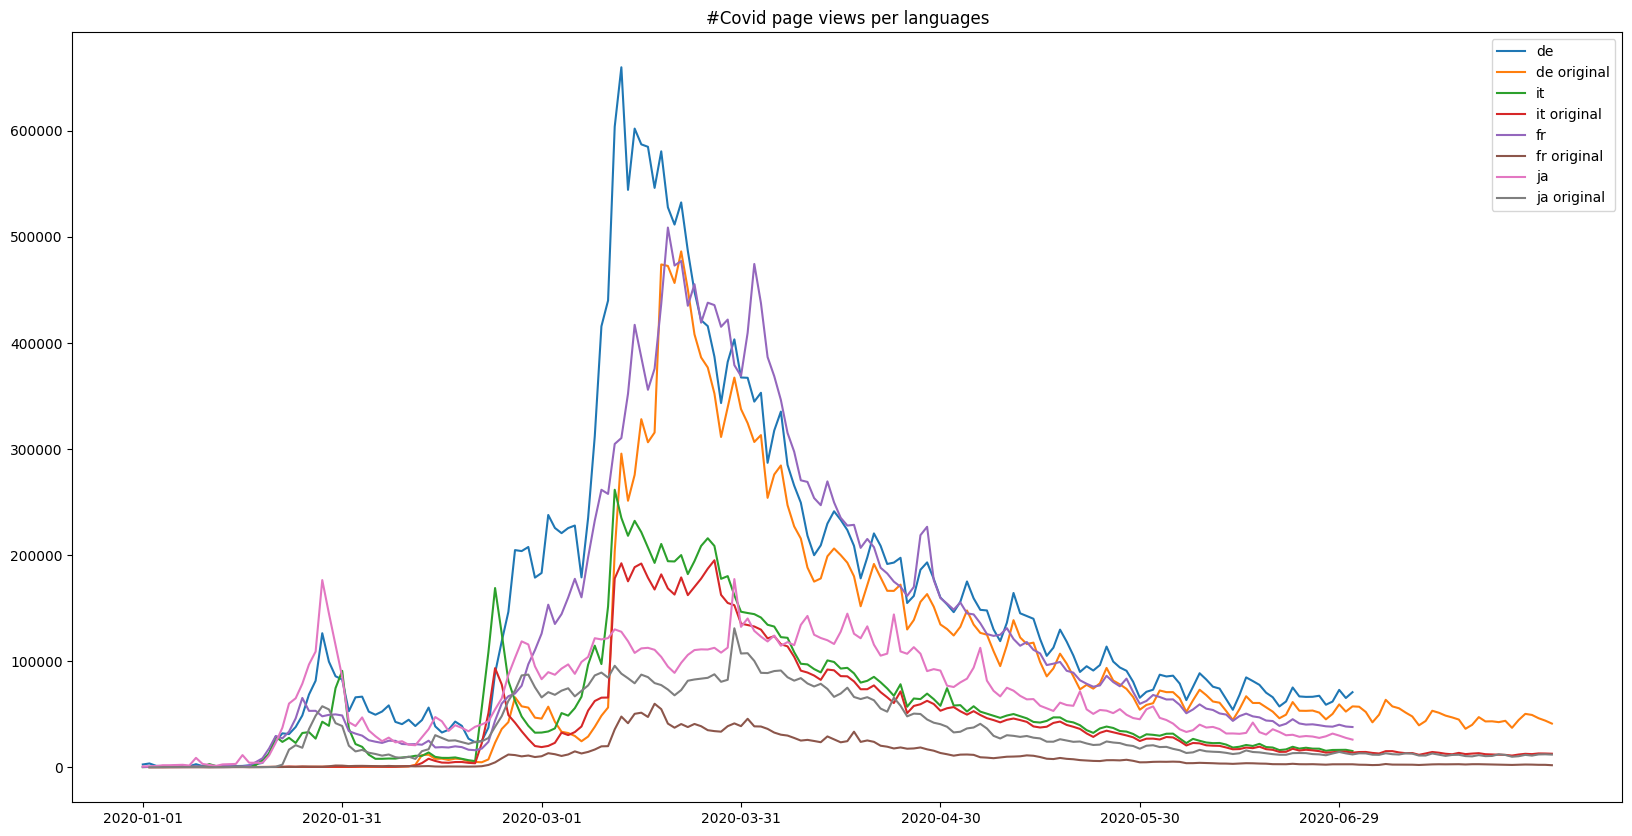

In [9]:
plt.figure(figsize=(20, 10))
agg = load_aggregated("data/aggregated_timeseries.json.gz")
df_agg = pd.DataFrame.from_dict(agg)
interventions = pd.read_csv('data/interventions.csv')
interventions = interventions.drop(interventions[interventions['lang']=='en'].index).drop(interventions[interventions['lang']=='ca'].index)
df_covid_agg = pd.DataFrame()
df_tmp  = pd.DataFrame()
lang = []
countries = ["de", "it", "fr", "ja"]
#interventions['lang']
for value in countries:
    df_tmp = wiki_to_df_extract(value, '20200101', '20200701').rename({'views': value}, axis='columns')
    df_tmp['date'] = df_tmp.index
    df_tmp['date'] = df_tmp['date'].apply(lambda s: pd.to_datetime(s[:8], format='%Y%m%d'))
    df_tmp = df_tmp.set_index('date')

    #Plot the evolution of the number of pages search on desktop per language
    plt.plot(df_tmp[value], label=str(value))
    df_tmp2 = pd.DataFrame.from_dict(df_agg[value]['covid']) + pd.DataFrame.from_dict(df_agg[value + ".m"]['covid'])
    df_tmp2 = df_tmp2.loc[df_tmp2.index > '2020-01-01'].drop(['percent', 'len'], axis= 1)
    plt.plot(df_tmp2, label=str(value) + " original")
    df_covid_agg = pd.concat([df_covid_agg, df_tmp], axis= 1)
    print(value)
print(df_covid_agg)
plt.legend()
plt.title("#Covid page views per languages")
skip = 30 #To show only the date on x-axis every month
plt.xticks(df_tmp.index[::skip])
plt.show()

In [27]:
'''
Function to be used within data fetching script
Inputs : 
    - json_obj : dict that was fetched in the given iteration of the script
    - return_df : final df that will be return at the end of the script
Output : concatenated df
'''
def json_to_df2(json_obj, return_df):
    #Create df from json with nested list
    #if json_obj.get('title') == "Not found.":
    #    print("Not found")
    #    return return_df
    try:
        df = pd.json_normalize(json_obj, record_path = ['items']).set_index(['timestamp', 'article']).drop(labels = ['project', 'granularity'
        , 'access', 'agent'], axis = 1)
    except:
        print(json_obj)
    #concatenation
    return  pd.concat([return_df, df])

In [28]:

df_covid_articles = pd.read_csv(COVID_RELATED_ARTICLES_PATH)
df_covid_articles_country = df_covid_articles.loc[df_covid_articles.project == "fr.wikipedia"]['page']
df_agg_country = pd.DataFrame()
for page in df_covid_articles_country:
    page = page.replace(' ', '_')
    page = urllib.parse.quote(page)
    page = page.replace('/', """%2F""")
    page = page.replace('?', """%3F""")
    url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/fr.wikipedia.org/all-access/user/{}/daily/20200101/20200701'.format(page)
    header = {'User-Agent' : 'Robin Debalme (academic project; robin.debalme@epfl.ch; https://github.com/epfl-ada/ada-2022-project-thedatadiggers22)'}
    try:
        r = requests.get(url, headers = header).json()
    except:
        print("Bad request")
    df_agg_country = json_to_df2(r, df_agg_country)


In [70]:
df_verif_fr = df_agg_country.reset_index()
#df_verif_fr = df_verif_fr.loc[df_verif_fr['timestamp'] < '2020040300']
#df_verif_fr = df_verif_fr.loc[df_verif_fr['timestamp'] > '2020032800']
#print(df_verif_fr.sort_values('views', ascending= False).head(30))
#df_verif_fr = df_verif_fr.loc[df_verif_fr['timestamp'] < '2020040300']
print(df_verif_fr.loc[df_verif_fr['timestamp'] == '2020033100'].sort_values('views', ascending= False).head(10))


        timestamp                                            article  views
16124  2020033100                         Maladie_à_coronavirus_2019  22434
5524   2020033100  Coronavirus_2_du_syndrome_respiratoire_aigu_sé...   5686
9705   2020033100                                           SARS-CoV   3685
16764  2020033100                    Test_diagnostique_du_SARS-CoV-2   2344
3888   2020033100                             Krach_boursier_de_2020   2218
13804  2020033100           Enzyme_de_conversion_de_l'angiotensine_2   1518
14234  2020033100                    USS_Theodore_Roosevelt_(CVN-71)    834
1124   2020033100                                        Tocilizumab    543
14051  2020033100          Marché_de_gros_de_fruits_de_mer_de_Huanan    491
10498  2020033100    Catégorie:Mort_de_la_maladie_à_coronavirus_2019    467


In [85]:
print(df_verif_fr.loc[df_verif_fr['timestamp'] == '2020040300'].sort_values('views', ascending= False).head(10))

        timestamp                              article  views
4387   2020040300       Pandémie_de_Covid-19_en_France  55109
11633  2020040300                 Pandémie_de_Covid-19  46169
10194  2020040300       Pandémie_de_Covid-19_en_Italie  28040
1911   2020040300      Pandémie_de_Covid-19_en_Algérie  24727
16127  2020040300           Maladie_à_coronavirus_2019  17833
2976   2020040300  Pandémie_de_Covid-19_aux_États-Unis  15625
9525   2020040300      Pandémie_de_Covid-19_en_Espagne  12770
17135  2020040300     Pandémie_de_Covid-19_en_Belgique  11229
12004  2020040300        Pandémie_de_Covid-19_au_Maroc   9941
5619   2020040300    Pandémie_de_Covid-19_en_Allemagne   7612


In [88]:
#The peak is due to new data that has been added to the wikipedia page views datasets.

for elem in df_verif_fr.loc[df_verif_fr['timestamp'] == '2020040300'].sort_values('views', ascending= False).head(10)['article']:
    print(df_verif_fr.loc[df_verif_fr['article'] == elem].loc[df_verif_fr['timestamp'] < '2020041000'].sort_values('views', ascending= False).head(10))

       timestamp                         article  views
4390  2020040600  Pandémie_de_Covid-19_en_France  59894
4389  2020040500  Pandémie_de_Covid-19_en_France  55396
4387  2020040300  Pandémie_de_Covid-19_en_France  55109
4391  2020040700  Pandémie_de_Covid-19_en_France  54642
4392  2020040800  Pandémie_de_Covid-19_en_France  51562
4386  2020040200  Pandémie_de_Covid-19_en_France  47095
4388  2020040400  Pandémie_de_Covid-19_en_France  46333
4393  2020040900  Pandémie_de_Covid-19_en_France  46092
4385  2020040100  Pandémie_de_Covid-19_en_France   1981
        timestamp               article  views
11619  2020032000  Pandémie_de_Covid-19  65319
11632  2020040200  Pandémie_de_Covid-19  48195
11633  2020040300  Pandémie_de_Covid-19  46169
11634  2020040400  Pandémie_de_Covid-19  43381
11635  2020040500  Pandémie_de_Covid-19  35715
11636  2020040600  Pandémie_de_Covid-19  35490
11637  2020040700  Pandémie_de_Covid-19  33893
11638  2020040800  Pandémie_de_Covid-19  32146
11639  2020040900

In [8]:
def get_redirect_articles(title, lang, df_articles):
    S = requests.Session()

    URL = "https://{}.wikipedia.org/w/api.php".format(lang)

    PARAMS = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "redirects"
    }
    try:
        R = S.get(url=URL, params=PARAMS)
        DATA = R.json()
        if DATA['query'].get('pages') is None:
            return []
        PAGES = DATA["query"]["pages"]
        res = []
        for k, v in PAGES.items():
            if v.get("redirects") is not None:
                for re in v["redirects"]:
                    if re["title"] not in df_articles.values:
                        res.append(re["title"])
    except:
        print("Error request Redirection")
        print(DATA)
        res = []
    
    return res